In [2]:
image_paths = {
    '2018': 'dataset/2018/m_3912112_sw_10_060_20180718.tif',
    '2020': 'dataset/2020/m_3912112_sw_10_060_20200709.tif',
    '2022': 'dataset/2022/m_3912112_sw_10_060_20220714.tif'
}

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import reshape_as_image
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [4]:
with rasterio.open(image_paths['2018']) as src:
    image = reshape_as_image(src.read())
    print(f'Image shape: {image.shape}')  # (height, width, bands)

Image shape: (12210, 9610, 4)


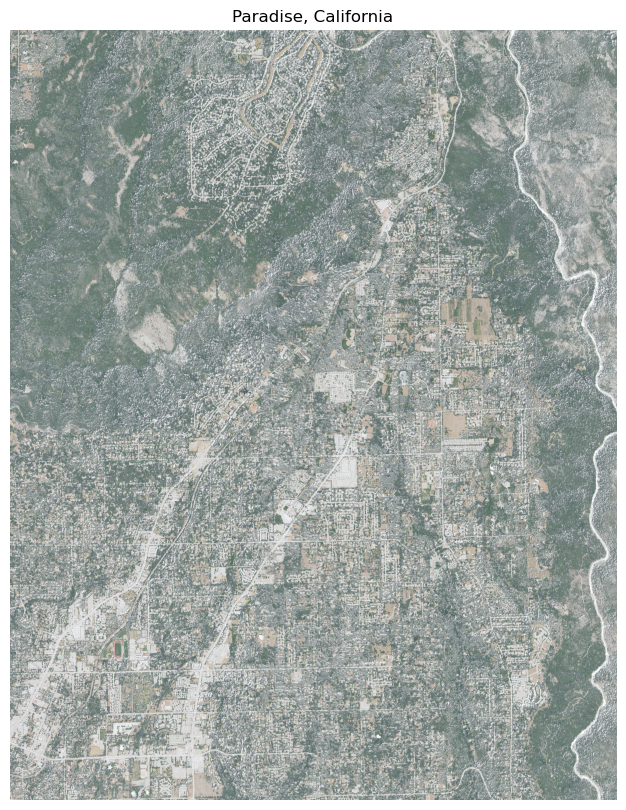

In [5]:
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.title('Paradise, California')
plt.axis('off')
plt.show()

In [18]:
def cluster_and_plot_image_v1(image_path, n_clusters=2, colors=['red', 'green'], output_path='clustered_image.tif'):
    """
    Clusters an image using K-means and displays the original and clustered images side by side.
    
    Parameters:
    - image_path: str, path to the input image
    - n_clusters: int, number of clusters for K-means
    - colors: list, colors for each cluster in the output plot
    - output_path: str, path to save the clustered output image
    """
    # Open the image and read the bands
    with rasterio.open(image_path) as src:
        # Read all bands into an array
        image = src.read()  # Shape: (bands, height, width)
        meta = src.meta  # Store metadata for saving later

    # Reshape the image array for KMeans (bands, height, width) -> (height*width, bands)
    pixels = image.reshape(image.shape[0], -1).T  # Shape: (height*width, bands)

    # Apply KMeans clustering
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=0).fit(pixels)
    labels = kmeans.labels_

    # Reshape labels to match the original image shape (height, width)
    label_image = labels.reshape((image.shape[1], image.shape[2]))

    # Set up the subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Define a colormap based on the number of clusters and colors provided
    cmap = mcolors.ListedColormap(colors[:n_clusters])

    # Display the original image (assuming it's a 3-band RGB image)
    ax[0].imshow(np.transpose(image[:3], (1, 2, 0)))
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    # Display the K-means clustered (labeled) image
    im = ax[1].imshow(label_image, cmap=cmap)  # Colormap for distinct classes
    ax[1].set_title("K-Means Clustered Image")
    ax[1].axis("off")

    # Add color bar to the clustered image
    cbar = plt.colorbar(im, ax=ax[1], ticks=range(n_clusters))
    cbar.set_label('Cluster ID')
    cbar.set_ticklabels([f'Cluster {i+1}' for i in range(n_clusters)])

    plt.show()

    # Save the labeled image as a new raster
    with rasterio.open(f'labels/{output_path}', 'w', **meta) as dst:
        dst.write(label_image.astype(rasterio.uint8), 1)  # Save as single-band labeled raster

In [10]:
import rasterio
from rasterio.plot import show
from sklearn.cluster import MiniBatchKMeans
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from rasterio.enums import ColorInterp

def cluster_and_plot_image(image_path, n_clusters=2, colors=['green', 'brown'], labels_mapping=None, output_path='clustered_image.tif'):
    """
    Clusters an image using K-means and displays the original and clustered images side by side.
    Saves the labeled image with color coding.
    """
    # Open the image and read the bands
    with rasterio.open(image_path) as src:
        image = src.read()  # Shape: (bands, height, width)
        meta = src.meta

    # Reshape for clustering
    pixels = image.reshape(image.shape[0], -1).T

    # KMeans clustering
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=0).fit(pixels)
    labels = kmeans.labels_
    label_image = labels.reshape((image.shape[1], image.shape[2]))

    # Create RGB array for color-coded output
    color_mapping = {0: [255, 255, 255],  # White for Not Forest
                     1: [0, 128, 0]}  # Green for Forest
    color_coded_image = np.zeros((image.shape[1], image.shape[2], 3), dtype=np.uint8)

    for label, color in color_mapping.items():
        color_coded_image[label_image == label] = color

    # Set up subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    cmap = mcolors.ListedColormap(colors[:n_clusters])
    ax[0].imshow(np.transpose(image[:3], (1, 2, 0)))
    ax[0].set_title("Original Image")
    ax[0].axis("off")
    im = ax[1].imshow(label_image, cmap=cmap)
    ax[1].set_title("K-Means Clustered Image")
    ax[1].axis("off")
    plt.colorbar(im, ax=ax[1], ticks=range(n_clusters), label='Cluster')

    plt.show()

    # Save color-coded raster
    meta.update({
        "count": 3,  # RGB image
        "dtype": "uint8",  # Update data type for color image
        "interleave": "pixel"
    })
    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(color_coded_image[:, :, 0], 1)  # Red channel
        dst.write(color_coded_image[:, :, 1], 2)  # Green channel
        dst.write(color_coded_image[:, :, 2], 3)  # Blue channel
        dst.colorinterp = [ColorInterp.red, ColorInterp.green, ColorInterp.blue]


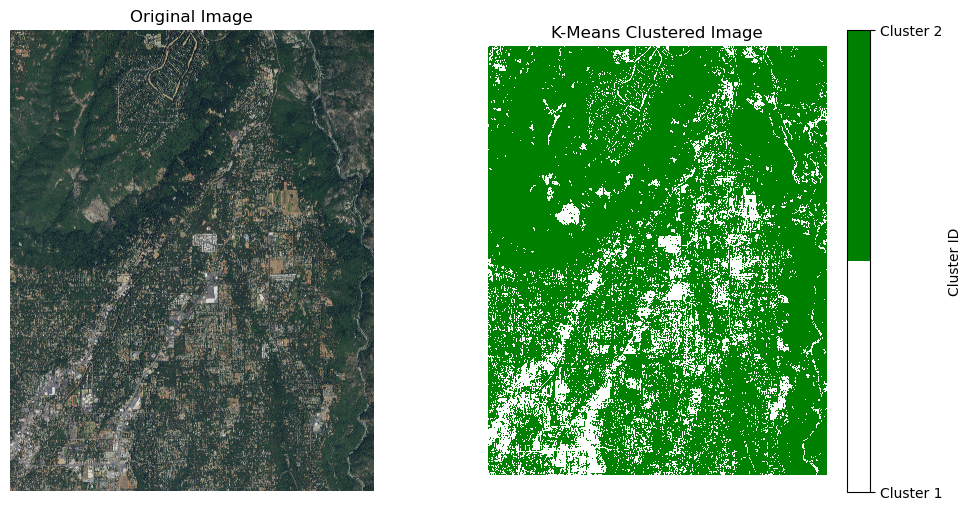

In [20]:
cluster_and_plot_image_v1(image_path=image_paths['2018'], n_clusters=2, colors=['white', 'green'], output_path='clustered_image_2018_v1.tif')

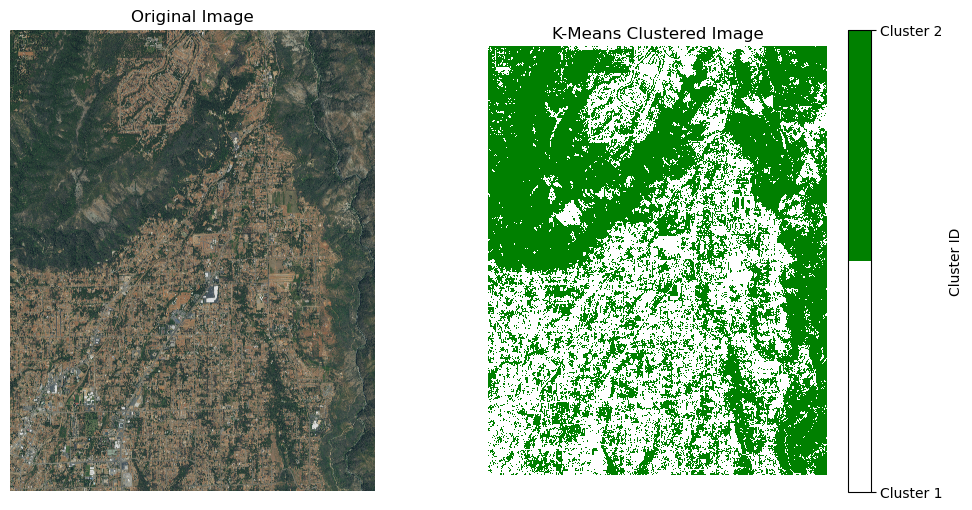

In [23]:

cluster_and_plot_image_v1(image_path=image_paths['2020'], n_clusters=2, colors=['white', 'green'], output_path='clustered_image_2020_v1.tif')

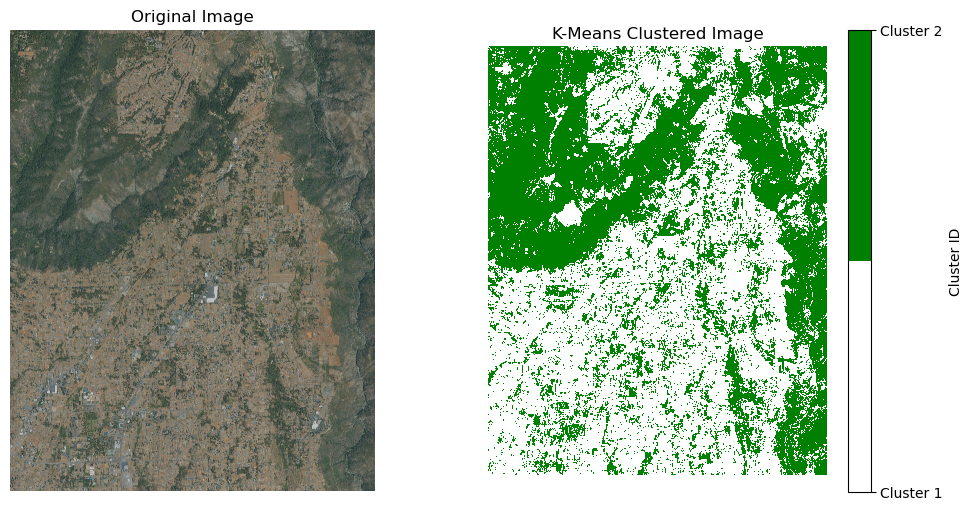

In [24]:

cluster_and_plot_image_v1(image_path=image_paths['2022'], n_clusters=2, colors=['white', 'green'], output_path='clustered_image_2022_v1.tif')

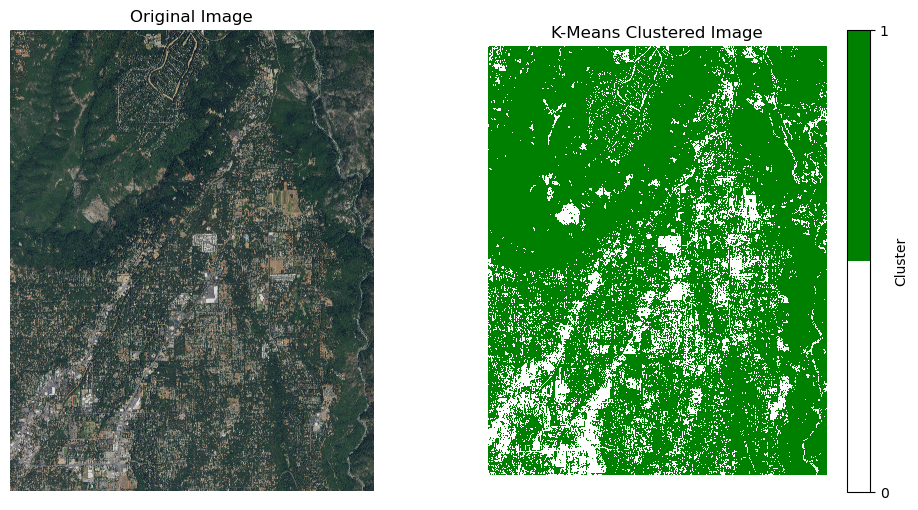

In [ ]:
labels_mapping = {0: 'Not Forest', 1: 'Forest'}  # Map cluster IDs to descriptive labels
cluster_and_plot_image(image_paths['2018'], n_clusters=2, colors=['white', 'green'], labels_mapping=labels_mapping, output_path='labels/saved_labelled_2018.tif')

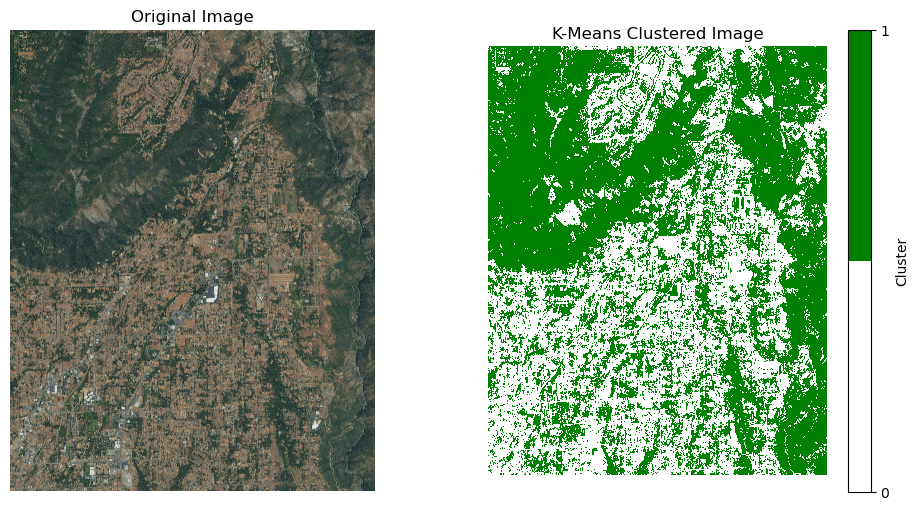

In [12]:
labels_mapping = {0: 'Not Forest', 1: 'Forest'}  # Map cluster IDs to descriptive labels
cluster_and_plot_image(image_paths['2020'], n_clusters=2, colors=['white', 'green'], labels_mapping=labels_mapping, output_path='labels/saved_labelled_2020.tif')

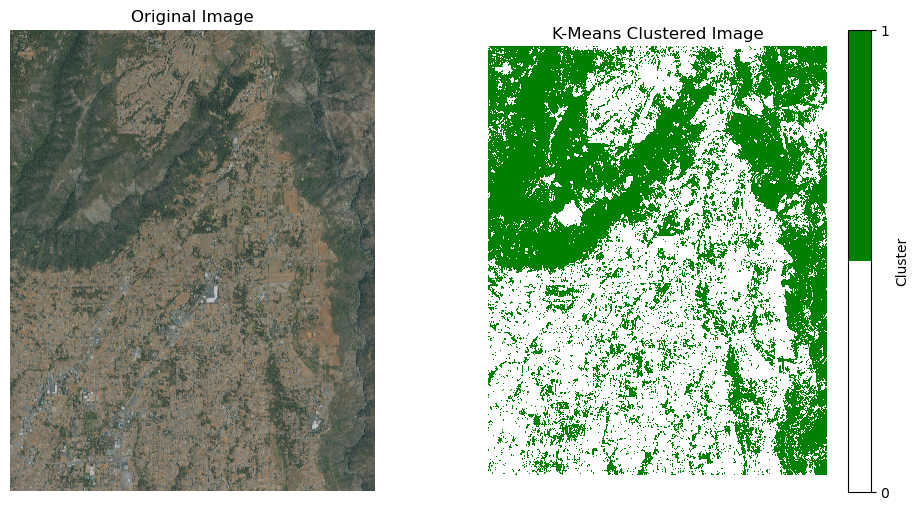

In [13]:
labels_mapping = {0: 'Not Forest', 1: 'Forest'}  # Map cluster IDs to descriptive labels
cluster_and_plot_image(image_paths['2022'], n_clusters=2, colors=['white', 'green'], labels_mapping=labels_mapping, output_path='labels/saved_labelled_2022.tif')

In [11]:
import rasterio
import numpy as np

def inspect_labeled_image(label_path):
    """
    Inspects a labeled raster image, displaying basic information and unique values.
    
    Parameters:
    - label_path: str, path to the labeled raster image
    """
    with rasterio.open(label_path) as src:
        # Read the first (and only) band containing the labels
        label_image = src.read(1)
        
        # Print basic metadata
        print("Image Width:", src.width)
        print("Image Height:", src.height)
        print("Data Type:", label_image.dtype)
        
        # Display unique label values
        unique_labels = np.unique(label_image)
        print("Unique Labels (Clusters):", unique_labels)
        
        # Display a small sample of the data
        print("Sample Data (first 5x5 pixels):")
        print(label_image[:5, :5])

# Example usage
inspect_labeled_image('labels/saved_labelled_2018.tif')

Image Width: 9610
Image Height: 12210
Data Type: uint8
Unique Labels (Clusters): [0 1]
Sample Data (first 5x5 pixels):
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


In [27]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import matplotlib.colors as mcolors

def plot_labeled_image(image_path):
    """
    Plots a labeled raster image with a custom colormap (green for Forest, white for Not Forest).

    Parameters:
    - image_path: str, path to the labeled raster file
    """
    # Open the raster and read the first band
    with rasterio.open(image_path) as src:
        img = src.read(1)  # Read the first band
        img = np.array(img, dtype=np.uint8)

    # Define a custom colormap: 'white' for Not Forest (0), 'green' for Forest (1)
    cmap = mcolors.ListedColormap(['white', 'green'])
    bounds = [0, 1, 2]  # Boundaries for colormap
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Plot the image with the custom colormap
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap=cmap, norm=norm)
    plt.colorbar(ticks=[0.5, 1.5], label="Labels", format=lambda x, _: "Not Forest" if x < 1 else "Forest")
    plt.title("Forest and Not Forest Labels")
    plt.axis("off")
    plt.show()


In [29]:
def plot_label_image(label_image):
    with rasterio.open(label_image) as src:
        img = src.read(1)
        img = np.array(img, dtype=np.uint8)

    # Define a custom colormap
    cmap = mcolors.ListedColormap(['green', 'white'])  # 'white' for Not Forest, 'green' for Forest
    bounds = [0, 1, 2]  # Define bounds for the colormap (0 -> Not Forest, 1 -> Forest)
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Plot the image with the custom colormap
    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap=cmap, norm=norm)
    plt.colorbar(ticks=[0.5, 1.5], label="Labels", format=lambda x, _: "Forest" if x < 1 else "Not Forest")
    plt.title("Forest and Not Forest Labels")
    plt.axis("off")
    plt.show()


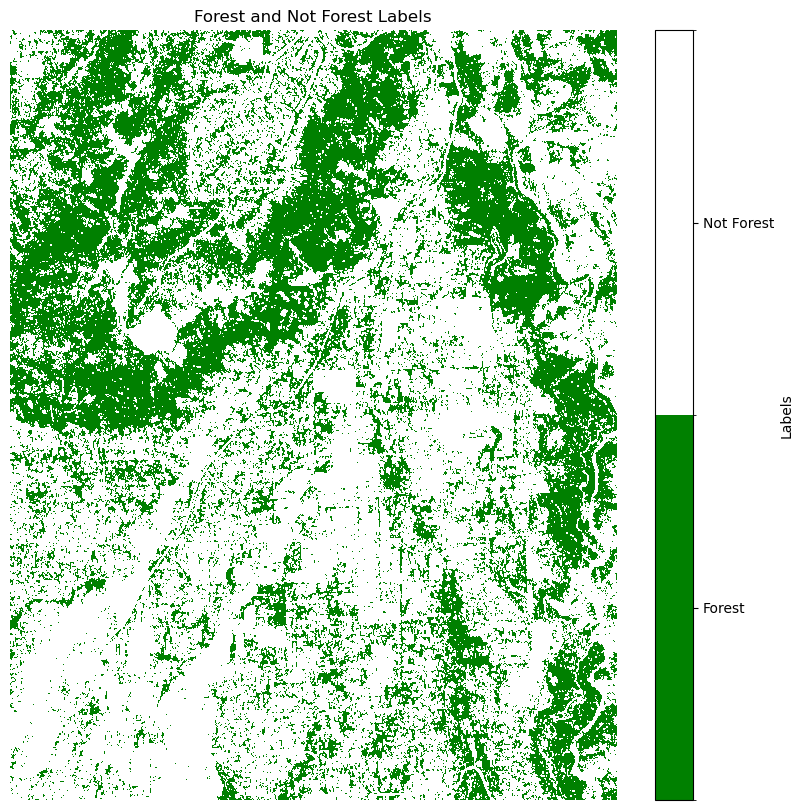

In [32]:
plot_label_image('labels/saved_labelled_2018.tif')

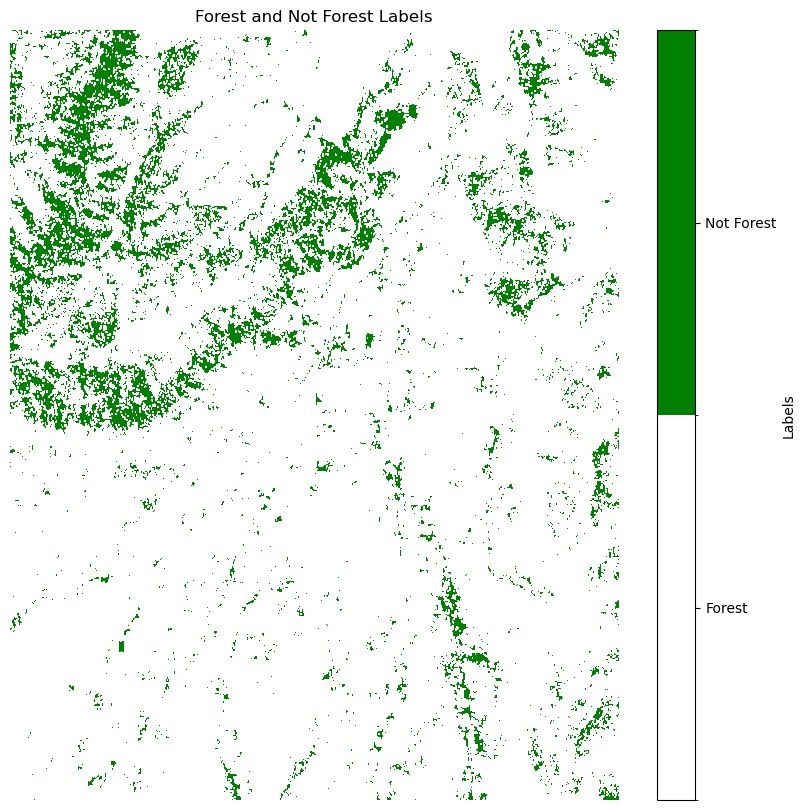

In [24]:
plot_label_image('labels/saved_labelled_2020.tif')

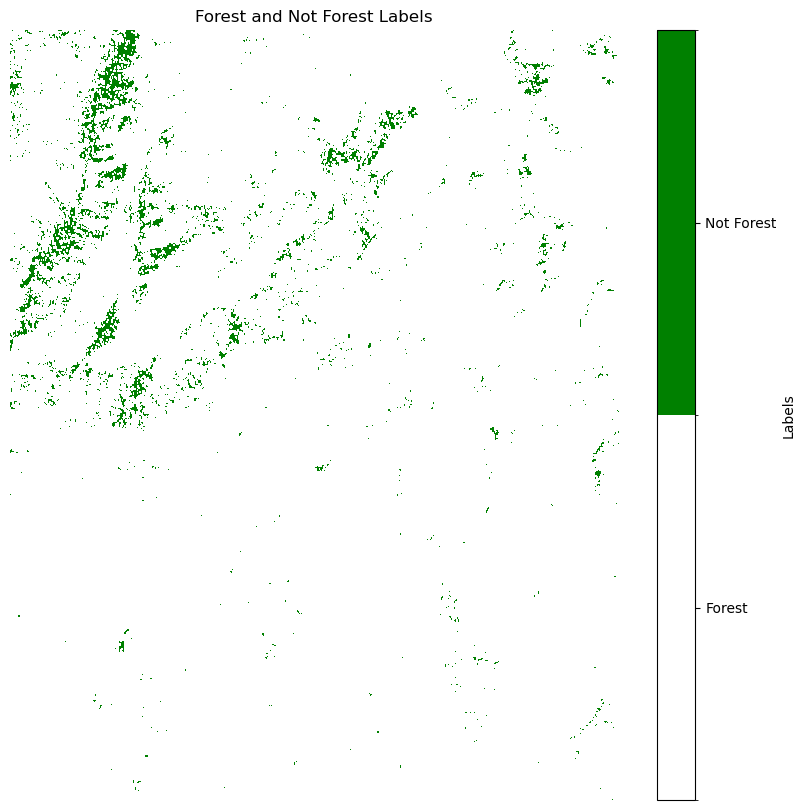

In [23]:
plot_label_image('labels/saved_labelled_2022.tif')

In [ ]:

def calculate_and_plot_forest_area_by_year(image_paths, years, save_path=None):
    """
    Reads multiple labeled images, calculates forest and non-forest areas for each year,
    and creates a bar plot showing the areas for each year as individual pairs.
    
    Parameters:
    - image_paths: list of str, paths to the labeled raster images
    - years: list of int, years corresponding to each image path
    """
    areas = []  # To store forest and non-forest areas for each year
    
    for image_path in image_paths:
        if not os.path.exists(image_path):
            print(f"File not found: {image_path}")
            areas.append((0, 0))  # Add 0s if file is missing
            continue
        
        with rasterio.open(image_path) as src:
            label_image = src.read(1)  # Read the first (and only) band
            
            # Calculate the area by counting pixels in each category
            forest_area = np.sum(label_image == 1)  # Assuming 1 represents forest
            non_forest_area = np.sum(label_image == 0)  # Assuming 0 represents non-forest
            
            # Append results for each year
            areas.append((forest_area, non_forest_area))
            
            # Print individual image areas (optional)
            print(f"Image: {image_path}")
            print(f"Forest Area: {forest_area}")
            print(f"Non-Forest Area: {non_forest_area}\n")
    
    # Separate forest and non-forest areas for plotting
    forest_areas = [area[0] for area in areas]
    non_forest_areas = [area[1] for area in areas]

    # Plot forest and non-forest areas for each year as individual pairs
    index = np.arange(len(years) * 2)  # One bar per forest and non-forest pair
    bar_labels = [f'{year} Forest' if i % 2 == 0 else f'{year} Non-Forest' for i, year in enumerate(np.repeat(years, 2))]
    
    plt.figure(figsize=(10, 6))
    plt.bar(index[::2], forest_areas, label='Forest', color='green', width=0.4, align='center')
    plt.bar(index[1::2], non_forest_areas, label='Non-Forest', color='brown', width=0.4, align='center')
    
    plt.xlabel('Year and Category')
    plt.ylabel('Area (in pixels)')
    plt.title('Forest and Non-Forest Areas by Year')
    plt.xticks(index, bar_labels, rotation=45, ha='right')
    plt.legend(['Forest', 'Non-Forest'])
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, format='png', dpi=300)
        print(f"Plot saved to {save_path}")
    
    plt.show()

Image: labels/saved_labelled_2018.tif
Forest Area: 92133277
Non-Forest Area: 25204823

Image: labels/saved_labelled_2020.tif
Forest Area: 69321235
Non-Forest Area: 51533665

Image: labels/saved_labelled_2022.tif
Forest Area: 55889818
Non-Forest Area: 64965082

Plot saved to insight.png


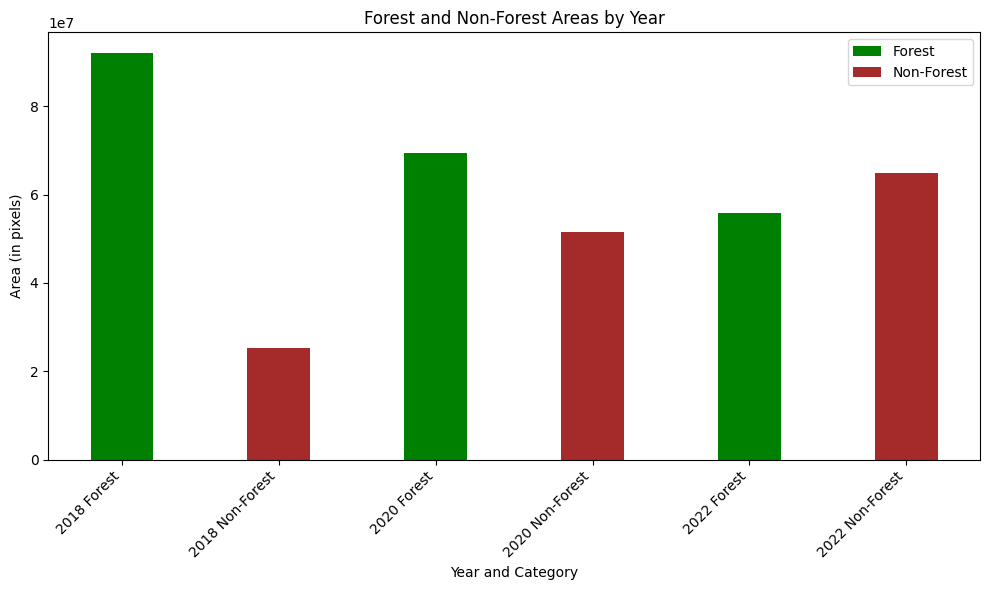

In [ ]:
years = [2018, 2020, 2022]
label_paths = [f'labels/saved_labelled_{x}.tif' for x in years]
plt = calculate_and_plot_forest_area_by_year(label_paths, years, save_path='insight.png')

In [4]:
import rasterio

tiff_file = image_paths["2018"]

# Open the TIFF file
with rasterio.open(tiff_file) as dataset:
    # Print general metadata
    print("General Metadata:")
    print(dataset.meta)

    # Print CRS (Coordinate Reference System)
    print("\nCRS (Coordinate Reference System):")
    print(dataset.crs)

    # Print bounds of the raster
    print("\nBounds:")
    print(dataset.bounds)

    # Print transform information
    print("\nTransform:")
    print(dataset.transform)

    # Print file's tags
    print("\nTags:")
    print(dataset.tags())

    # Print detailed metadata (band-specific metadata)
    print("\nBand Metadata:")
    for i in dataset.indexes:  # Iterate through all bands
        print(f"Band {i} metadata:")
        print(dataset.tags(i))

    # Print raster dimensions
    print("\nRaster Dimensions:")
    print(f"Width: {dataset.width}, Height: {dataset.height}, Number of Bands: {dataset.count}")

General Metadata:
{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 9610, 'height': 12210, 'count': 4, 'crs': CRS.from_epsg(26910), 'transform': Affine(0.6, 0.0, 617538.0,
       0.0, -0.6, 4408086.0)}

CRS (Coordinate Reference System):
EPSG:26910

Bounds:
BoundingBox(left=617538.0, bottom=4400760.0, right=623304.0, top=4408086.0)

Transform:
| 0.60, 0.00, 617538.00|
| 0.00,-0.60, 4408086.00|
| 0.00, 0.00, 1.00|

Tags:
{'AREA_OR_POINT': 'Area', 'TIFFTAG_IMAGEDESCRIPTION': 'OrthoVista', 'TIFFTAG_RESOLUTIONUNIT': '1 (unitless)', 'TIFFTAG_SOFTWARE': 'Trimble Germany GmbH', 'TIFFTAG_XRESOLUTION': '1', 'TIFFTAG_YRESOLUTION': '1'}

Band Metadata:
Band 1 metadata:
{'STATISTICS_APPROXIMATE': 'YES', 'STATISTICS_MAXIMUM': '234', 'STATISTICS_MEAN': '63.474771962389', 'STATISTICS_MINIMUM': '5', 'STATISTICS_STDDEV': '45.632338359933', 'STATISTICS_VALID_PERCENT': '100'}
Band 2 metadata:
{'STATISTICS_APPROXIMATE': 'YES', 'STATISTICS_MAXIMUM': '231', 'STATISTICS_MEAN': '76.635256067722',

In [16]:
import rasterio
import numpy as np

def query_forest_regions(tiff_file, forest_label=1):
    """
    Queries forest regions from a given raster TIFF file.
    
    Args:
        tiff_file (str): Path to the TIFF file.
        forest_label (int): Label representing forest in the classification raster. Default is 1.
        
    Returns:
        dict: A dictionary containing forest area, non-forest area, and total area.
    """
    # Open the TIFF file
    with rasterio.open(tiff_file) as dataset:
        # Read the first band (assuming classification is in band 1)
        classification = dataset.read(1)
        
        # Calculate forest area
        forest_area = np.sum(classification == forest_label)
        
        # Calculate non-forest area (assuming non-forest is labeled as 0)
        non_forest_area = np.sum(classification != forest_label)
        
        # Total area
        total_area = classification.size
        
        # Calculate percentages
        forest_percentage = (forest_area / total_area) * 100
        non_forest_percentage = (non_forest_area / total_area) * 100
        
        # Return results
        return {
            "Forest Area": forest_area,
            "Non-Forest Area": non_forest_area,
            "Total Area": total_area,
            "Forest Percentage": forest_percentage,
            "Non-Forest Percentage": non_forest_percentage,
        }

# Example usage
tiff_path = "labels/saved_labelled_2022.tif"
forest_data = query_forest_regions(tiff_path)
print("Forest Query Results:")
for key, value in forest_data.items():
    print(f"{key}: {value}")

Forest Query Results:
Forest Area: 0
Non-Forest Area: 120854900
Total Area: 120854900
Forest Percentage: 0.0
Non-Forest Percentage: 100.0


In [ ]:
tiff_path = "labels/saved_labelled_2018.tif"
forest_data = query_forest_regions(tiff_path)
print("Forest Query Results:")
for key, value in forest_data.items():
    print(f"{key}: {value}")

Forest Query Results:
Forest Area: 92133277
Non-Forest Area: 25204823
Total Area: 117338100
Forest Percentage: 78.51948940710646
Non-Forest Percentage: 21.480510592893527


In [15]:
tiff_path = "labels/saved_labelled_2020.tif"
forest_data = query_forest_regions(tiff_path)
print("Forest Query Results:")
for key, value in forest_data.items():
    print(f"{key}: {value}")

Forest Query Results:
Forest Area: 0
Non-Forest Area: 120854900
Total Area: 120854900
Forest Percentage: 0.0
Non-Forest Percentage: 100.0


In [28]:
for year in [2018, 2020, 2022]:
    print(year)
    tiff_path = f"labels/clustered_image_{year}_v1.tif"
    forest_data = query_forest_regions(tiff_path)
    print("Forest Query Results:")

    for key, value in forest_data.items():
        print(f"{key}: {value}")

    print("=" * 60)

2018
Forest Query Results:
Forest Area: 92133277
Non-Forest Area: 25204823
Total Area: 117338100
Forest Percentage: 78.51948940710646
Non-Forest Percentage: 21.480510592893527
2020
Forest Query Results:
Forest Area: 69321235
Non-Forest Area: 51533665
Total Area: 120854900
Forest Percentage: 57.359060327715305
Non-Forest Percentage: 42.6409396722847
2022
Forest Query Results:
Forest Area: 55889818
Non-Forest Area: 64965082
Total Area: 120854900
Forest Percentage: 46.24538847824954
Non-Forest Percentage: 53.75461152175046
